In [137]:
import os

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import seaborn as sns
import plotly.express as px

import umap
import umap.umap_ as umap

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette

from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import (
    PowerTransformer,
    normalize
)

from sklearn.feature_extraction.text import (
    CountVectorizer,
)

from sklearn.feature_selection import chi2, mutual_info_classif

from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    pairwise_distances
)

In [139]:
full_dataset = pd.read_csv('../datasets/dish_type_results_25758.csv')

In [140]:
full_dataset.columns

Index(['title', 'ingredients', 'directions', 'link', 'source', 'NER',
       'NER_list', 'NER_len', 'directions_len', 'title_lower', 'NER_clean',
       'ingredients_str', 'cluster', 'verbs', 'lemmed_verbs', 'filtered_verbs',
       'set_verbs', 'clean_direction', 'pairs', 'pairs_set',
       'dish_type_response'],
      dtype='object')

In [141]:
npz_title = np.load('../datasets/title_embeddings_by_title.npz', allow_pickle=True)
npz_ingr = np.load('../datasets/ingredient_embeddings_by_title.npz', allow_pickle=True)
npz_dir = np.load('../datasets/verb_embeddings_by_title.npz', allow_pickle=True)

In [142]:
titles = full_dataset["title"]

In [143]:
# build DataFrames (index = title, cols = embedding dims)
df_ingr  = pd.DataFrame.from_dict({k: npz_ingr[k]  for k in npz_ingr.files},  orient='index')
df_dir   = pd.DataFrame.from_dict({k: npz_dir[k]   for k in npz_dir.files},   orient='index')
df_title = pd.DataFrame.from_dict({k: npz_title[k] for k in npz_title.files}, orient='index')

# re‐index
emb_ingr_matched  = df_ingr.reindex(titles).values
emb_dir_matched   = df_dir.reindex(titles).values
emb_title_matched = df_title.reindex(titles).values

In [144]:
# L2‑normalize
emb_title_norm = normalize(emb_title_matched, norm='l2', axis=1)
emb_ingr_norm  = normalize(emb_ingr_matched,  norm='l2', axis=1)
emb_dir_norm   = normalize(emb_dir_matched,   norm='l2', axis=1)

# Apply weights
w_title, w_ingr, w_dir = 0.3, 0.5, 0.5
emb_title_norm *= w_title
emb_ingr_norm  *= w_ingr
emb_dir_norm   *= w_dir

# Stack the embeddings
X = np.hstack([emb_title_norm, emb_ingr_norm, emb_dir_norm])
X_scaled = PowerTransformer().fit_transform(X)

## Optimal Clusters

In [145]:
umap_hd = umap.UMAP(
    n_components=60, n_neighbors=15, min_dist=0.02,
    metric='cosine', init='spectral', random_state=42
)
X_for_clustering = umap_hd.fit_transform(X_scaled)

c:\Users\alice\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [146]:
Z        = linkage(X_for_clustering, method='ward')

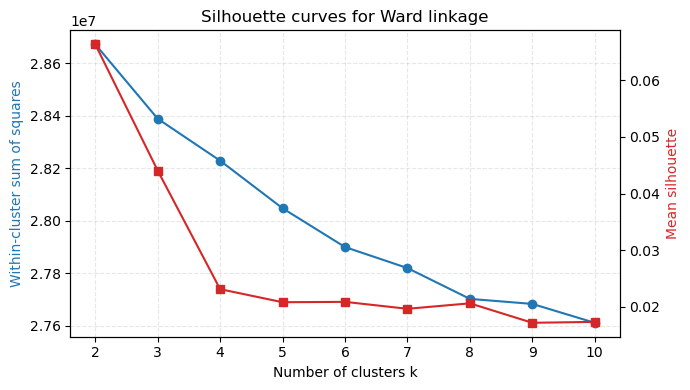

In [147]:
k_range          = range(2, 11)
silhouette_vals  = []
wcss_vals        = []
ch_vals          = []
db_vals          = []

for k in k_range:
    labels = fcluster(Z, t=k, criterion='maxclust')

    sil = silhouette_score(X_scaled, labels, metric='cosine')
    silhouette_vals.append(sil)

    inertia = 0.0
    for c in np.unique(labels):
        cluster_pts = X_scaled[labels == c]
        center      = cluster_pts.mean(axis=0)
        inertia    += ((cluster_pts - center) ** 2).sum()
    wcss_vals.append(inertia)

    ch_vals.append(calinski_harabasz_score(X_scaled, labels))
    db_vals.append(davies_bouldin_score(X_scaled, labels))

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(k_range, wcss_vals, marker='o', label='WCSS (elbow)')
ax1.set_xlabel('Number of clusters k')
ax1.set_ylabel('Within-cluster sum of squares', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(k_range, silhouette_vals, marker='s', color='tab:red', label='Silhouette')
ax2.set_ylabel('Mean silhouette', color='tab:red')

ax1.set_title('Silhouette curves for Ward linkage')
ax1.grid(True, linestyle='--', alpha=.3)
fig.tight_layout()
plt.show()

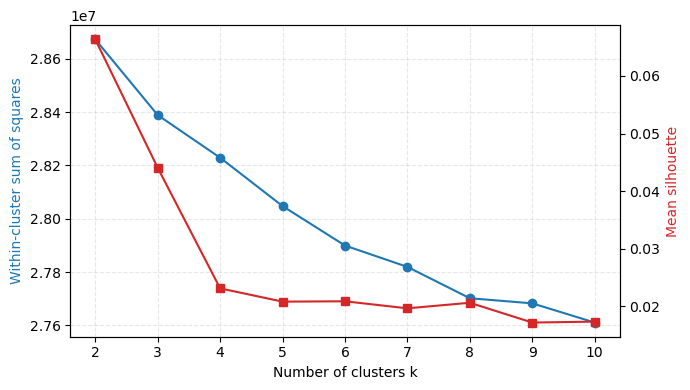

In [148]:
# os.makedirs('images', exist_ok=True)

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(k_range, wcss_vals, marker='o', label='WCSS (elbow)')
ax1.set_xlabel('Number of clusters k')
ax1.set_ylabel('Within-cluster sum of squares', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(k_range, silhouette_vals, marker='s', color='tab:red', label='Silhouette')
ax2.set_ylabel('Mean silhouette', color='tab:red')

ax1.grid(True, linestyle='--', alpha=.3)
fig.tight_layout()

fig.savefig('../images/ward_elbow_silhouette.png', dpi=300)

plt.show()

# 7 clusters

In [149]:
# Hierarchial CLustering
k        = 7
labels_h = fcluster(Z, t=k, criterion='maxclust')

full_dataset["cluster_hier"] = labels_h

In [ ]:
# the canonical names
cluster_names = [
    "Meat & Fish Mains",
    "Salads / Slaws / Dressings",
    "Pasta & Veg Bakes",
    "Soups & One-Pots",
    "Breakfast Bakes & Breads",
    "Drinks & Fruit Treats",
    "Desserts / Cookies / Cakes",
]

# build a corrected mapping from your observed cluster IDs → labels
corrected_map = {
    1: "Meat & Fish Mains",
    2: "Salads / Slaws / Dressings",
    3: "Soups & One-Pots",
    4: "Pasta & Veg Bakes",
    5: "Breakfast Bakes & Breads",
    6: "Drinks & Fruit Treats",
    7: "Desserts / Cookies / Cakes",
}

# apply it
merge['cluster_label'] = merge['cluster_hier'].map(corrected_map)

# sanity‐check
print(
    merge[['cluster_hier','cluster_label']]
         .drop_duplicates()
         .sort_values('cluster_hier')
)


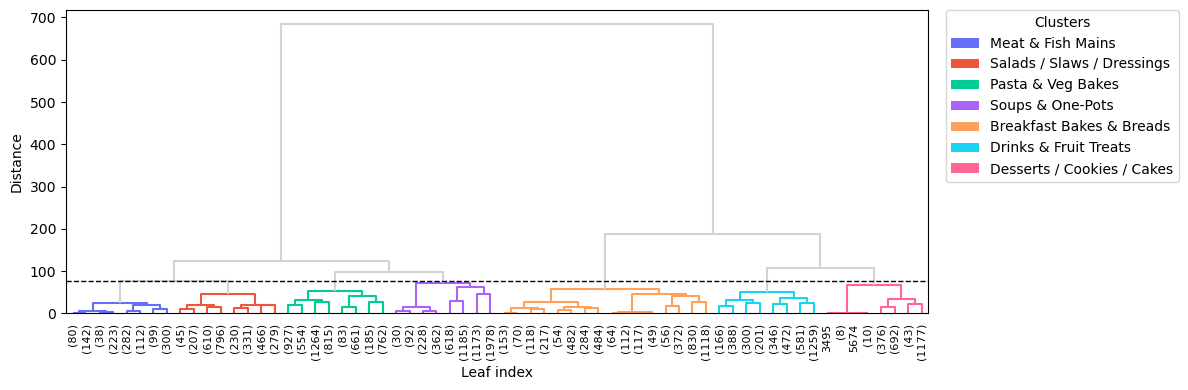

In [173]:
cluster_names = [
    "Meat & Fish Mains",
    "Salads / Slaws / Dressings",
    "Pasta & Veg Bakes",
    "Soups & One-Pots",
    "Breakfast Bakes & Breads",
    "Drinks & Fruit Treats",
    "Desserts / Cookies / Cakes",
]
base_palette = px.colors.qualitative.Plotly
my_colors   = base_palette[:7]

threshold = Z[-(k-1), 2] - 1e-12
set_link_color_palette(my_colors)

fig, ax = plt.subplots(figsize=(12, 4))
dendrogram(
    Z,
    color_threshold=threshold,
    above_threshold_color="lightgrey",
    truncate_mode="level", p=5,
    leaf_rotation=90, leaf_font_size=8,
    ax=ax
)
ax.axhline(threshold, color="k", ls="--", lw=1)
ax.set_ylabel("Distance")
ax.set_xlabel("Leaf index")

legend_handles = [Patch(facecolor=c) for c in my_colors]
ax.legend(legend_handles, cluster_names,
          title="Clusters",
          bbox_to_anchor=(1.02, 1),
          loc="upper left",
          borderaxespad=0.)

plt.tight_layout()
fig.savefig('../images/ward_dendrogram.png', dpi=300)
plt.show()

set_link_color_palette(None)

In [151]:
# UMAP Reduction for Visualization
reducer2d = umap.UMAP(
    n_components=2, n_neighbors=5, min_dist=0.01,
    metric='cosine', init='spectral', random_state=42
)

umap_2d = reducer2d.fit_transform(X_scaled)
full_dataset["umap_x"], full_dataset["umap_y"] = umap_2d[:, 0], umap_2d[:, 1]
full_dataset["text_snippet"] = full_dataset["title"].str.slice(0, 80)

c:\Users\alice\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [174]:
cluster_names = [
    "Meat & Fish Mains",
    "Salads / Slaws / Dressings",
    "Pasta & Veg Bakes",
    "Soups & One-Pots",
    "Breakfast Bakes & Breads",
    "Drinks & Fruit Treats",
    "Desserts / Cookies / Cakes",
]
base_palette = px.colors.qualitative.Plotly
my_colors   = base_palette[:7]   
color_map = {
    cluster_names[i]: my_colors[i]
    for i in range(len(cluster_names))
}

label_map = {i+1: cluster_names[i] for i in range(len(cluster_names))}
full_dataset["cluster_label"] = full_dataset["cluster_hier"].map(label_map)

fig = px.scatter(
    full_dataset,
    x="umap_x",
    y="umap_y",
    color="cluster_label",
    color_discrete_map=color_map,        
    category_orders={"cluster_label": cluster_names},
    hover_data=["text_snippet"],
    width=850,
    height=600
)

fig.update_layout(
    plot_bgcolor="white",
    paper_bgcolor="white",
    legend_title_text="Recipe category"
)

fig.show()

In [ ]:
CLUSTER_COL = "cluster_hier"
TITLE_COL   = "title"
N_PER_CLUST = 25
RANDOM_SEED = 42

rng = np.random.default_rng(RANDOM_SEED)

for cid in sorted(full_dataset[CLUSTER_COL].unique()):
    grp = full_dataset[full_dataset[CLUSTER_COL] == cid]
    n   = min(N_PER_CLUST, len(grp))
    sample_idx = rng.choice(grp.index, size=n, replace=False)

    print(f"\n=== Cluster {cid} — showing {n} of {len(grp)} recipes ===")
    for title in full_dataset.loc[sample_idx, TITLE_COL]:
        print(" •", title)

In [175]:
# count how many points in each cluster
counts = full_dataset['cluster_hier'].value_counts().sort_index()

# display as a nice table
counts_df = counts.reset_index()
counts_df.columns = ['cluster_id', 'n_elements']
print(counts_df)

   cluster_id  n_elements
0           1        1276
1           2        2964
2           3        5251
3           4        5666
4           5        4580
5           6        3713
6           7        2308


# In depth analysis

## Ingridients and verbs

In [176]:
CLUSTER_COL = "cluster_hier"
N_TOP       = 20
MIN_DF      = 5

def tokenise_cell(cell, trim="[],'\" "):
    toks = cell if isinstance(cell, list) else cell.split()
    return [t.strip(trim).lower() for t in toks if t.strip(trim)]


In [177]:
full_dataset['ing_doc'] = (full_dataset['NER_list']
                            .apply(tokenise_cell)
                            .str.join(' '))

full_dataset['verb_doc'] = (full_dataset['set_verbs']
                             .apply(tokenise_cell)
                             .str.join(' '))


In [178]:
def build_counts(docs, min_df):
    vec   = CountVectorizer(min_df=min_df)
    X     = vec.fit_transform(docs)
    vocab = np.array(vec.get_feature_names_out())
    return X, vocab, vec

def log_odds_df(X, labels, vocab, alpha=0.01):
    y0 = labels - labels.min()
    K  = y0.max() + 1
    V  = X.shape[1]

    cts = np.full((K, V), alpha, dtype=float)
    for k in range(K):
        cts[k] += np.asarray(X[y0 == k].sum(axis=0)).ravel()

    others = cts.sum(axis=0, keepdims=True) - cts
    with np.errstate(divide='ignore'):
        lor = np.log(cts) - np.log(others)

    return (pd.DataFrame(lor,
                         index=[f"cluster_{k+1}" for k in range(K)],
                         columns=vocab)
            .replace([np.inf, -np.inf], np.nan))

In [179]:
labels = full_dataset[CLUSTER_COL].values

X_ing, vocab_ing, _ = build_counts(full_dataset['ing_doc'], MIN_DF)
lor_ing = log_odds_df(X_ing, labels, vocab_ing)

X_verb, vocab_verb, _ = build_counts(full_dataset['verb_doc'], MIN_DF)
lor_verb = log_odds_df(X_verb, labels, vocab_verb)

In [180]:
def tidy_lor(df_lor, n_top):
    tidy = (df_lor
            .reset_index(drop=True)
            .stack()
            .reset_index(name='score')
            .rename(columns={'level_0': 'cluster', 'level_1': 'token'})
            .dropna(subset=['score']))


    tidy['cluster'] += 1

    # keep the most distinctive tokens
    return (tidy
            .sort_values(['cluster', 'score'], ascending=[True, False])
            .groupby('cluster')
            .head(n_top)
            .reset_index(drop=True))


top_ing   = tidy_lor(lor_ing,  N_TOP)
top_verbs = tidy_lor(lor_verb, N_TOP)

print("top_ing rows  :", len(top_ing))
print("top_verbs rows:", len(top_verbs))
print(top_ing.head())

top_ing rows  : 140
top_verbs rows: 140
   cluster       token     score
0        1  katakuriko  5.379129
1        1   swordfish  4.894101
2        1       jumbo  2.650448
3        1     tilapia  2.519434
4        1     fillets  2.145896


In [181]:
full_dataset[['cluster_hier','cluster_label']]

,cluster_hier,cluster_label
0,2,Salads / Slaws / Dressings
1,6,Drinks & Fruit Treats
2,7,Desserts / Cookies / Cakes
3,6,Drinks & Fruit Treats
4,3,Pasta & Veg Bakes
...,...,...
25753,5,Breakfast Bakes & Breads
25754,6,Drinks & Fruit Treats
25755,4,Soups & One-Pots
25756,3,Pasta & Veg Bakes


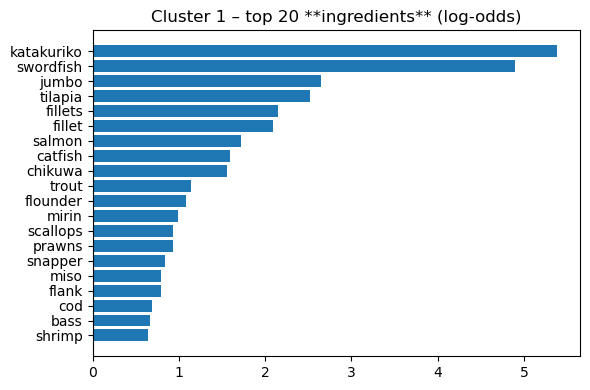

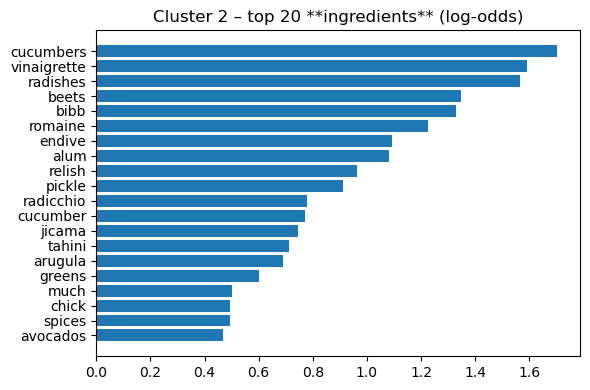

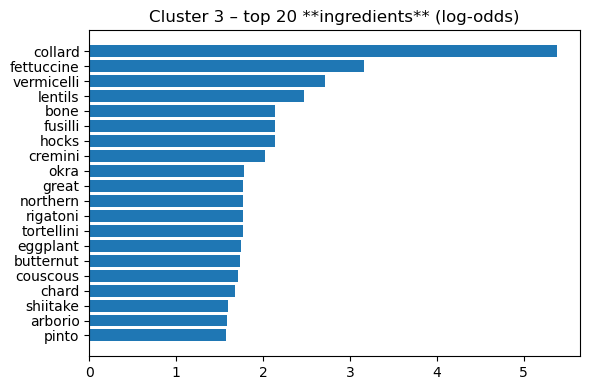

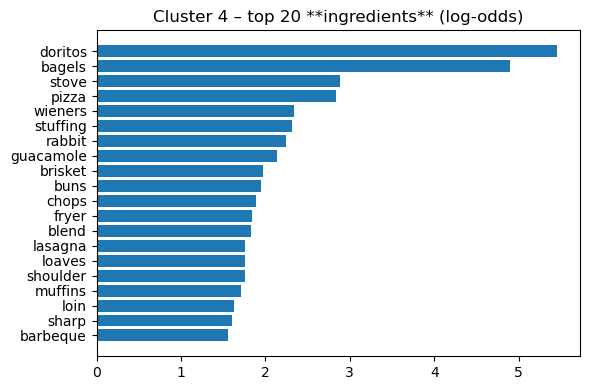

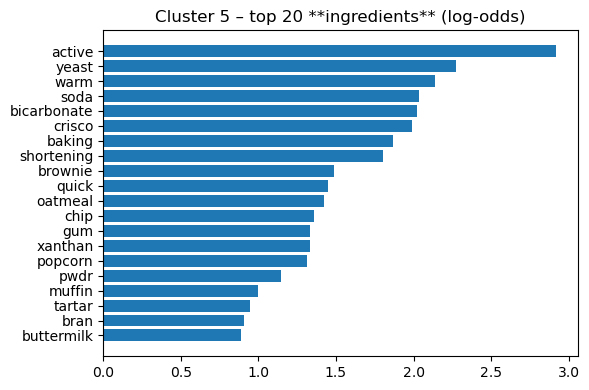

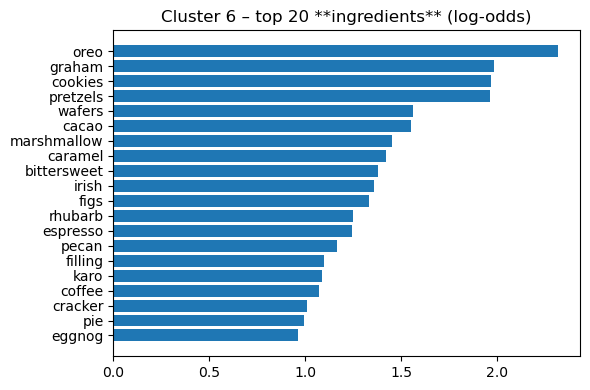

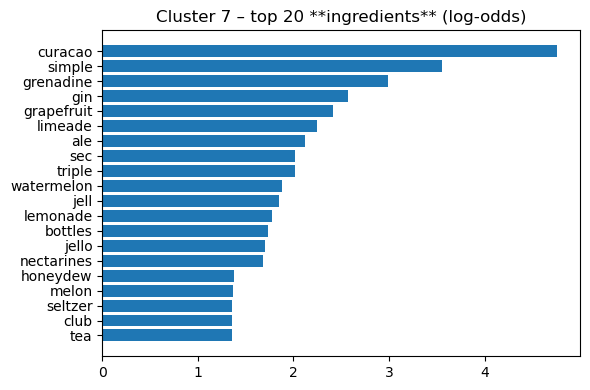

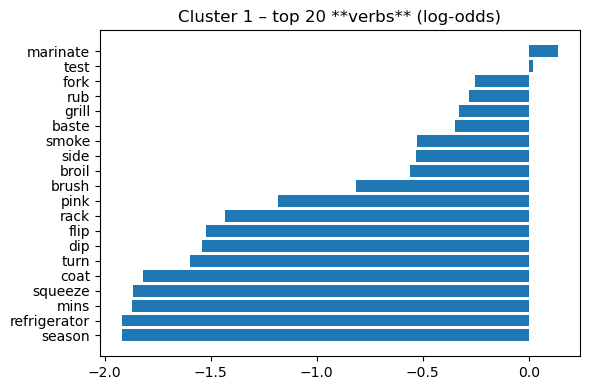

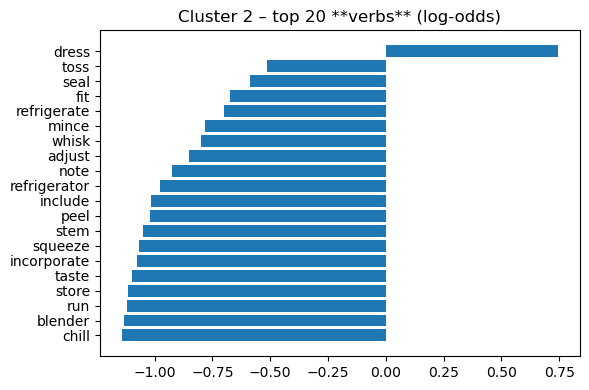

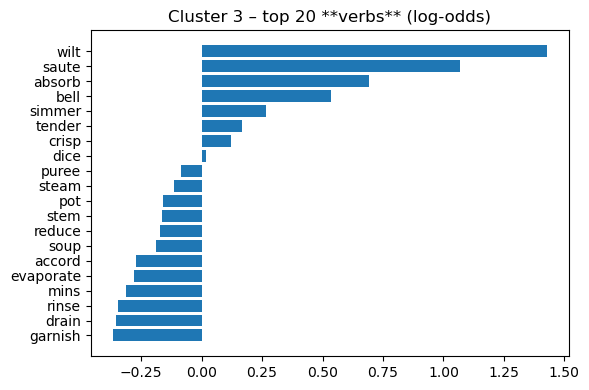

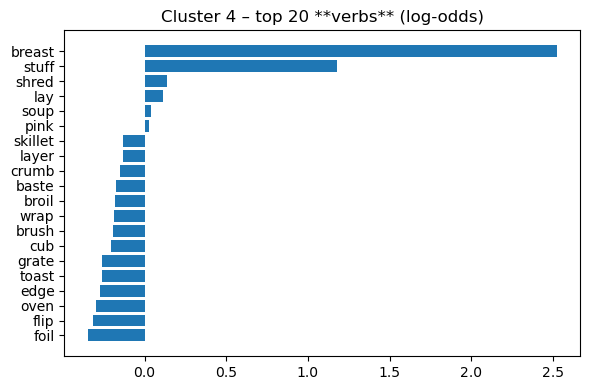

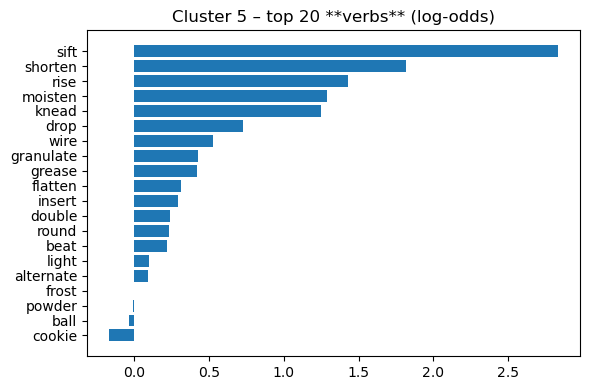

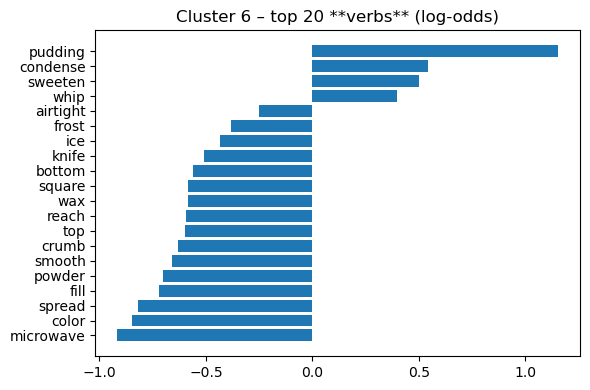

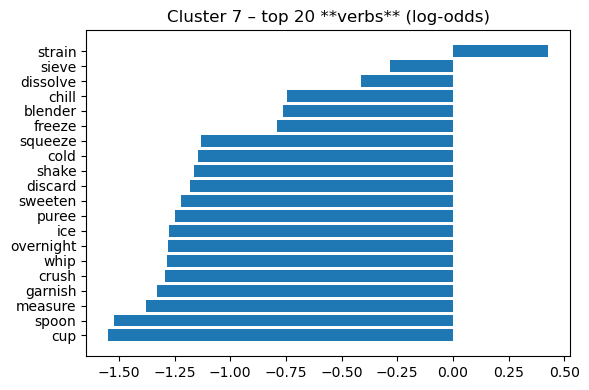

In [194]:
for cid, grp in top_ing.groupby('cluster'):
    plt.figure(figsize=(6, 4))
    plt.barh(grp['token'], grp['score'])
    plt.title(f"Cluster {cid} – top {N_TOP} **ingredients** (log-odds)")
    plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()

for cid, grp in top_verbs.groupby('cluster'):
    plt.figure(figsize=(6, 4))
    plt.barh(grp['token'], grp['score'])
    plt.title(f"Cluster {cid} – top {N_TOP} **verbs** (log-odds)")
    plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()


In [183]:
def dump(df, label):
    for cid, g in df.groupby('cluster'):
        print(f"\n=== Cluster {cid} – {label} ===")
        for t, s in zip(g['token'], g['score']):
            print(f" • {t:<18} {s:6.2f}")

dump(top_ing,  "ingredients")
dump(top_verbs, "verbs")


=== Cluster 1 – ingredients ===
 • katakuriko           5.38
 • swordfish            4.89
 • jumbo                2.65
 • tilapia              2.52
 • fillets              2.15
 • fillet               2.10
 • salmon               1.72
 • catfish              1.59
 • chikuwa              1.55
 • trout                1.14
 • flounder             1.08
 • mirin                0.99
 • scallops             0.94
 • prawns               0.94
 • snapper              0.84
 • miso                 0.80
 • flank                0.79
 • cod                  0.69
 • bass                 0.67
 • shrimp               0.64

=== Cluster 2 – ingredients ===
 • cucumbers            1.70
 • vinaigrette          1.59
 • radishes             1.57
 • beets                1.35
 • bibb                 1.33
 • romaine              1.22
 • endive               1.09
 • alum                 1.08
 • relish               0.96
 • pickle               0.91
 • radicchio            0.78
 • cucumber             0.77
 • jic

In [184]:
top_ing.to_csv("drivers_ingredients.csv", index=False)
top_verbs.to_csv("drivers_verbs.csv", index=False)

In [185]:
# mean absolute log-odds per cluster
pureness_ing  = lor_ing.abs().mean(axis=1)
pureness_verb = lor_verb.abs().mean(axis=1)
summary = pd.DataFrame({
    'cluster': pureness_ing.index,
    'ing_purity':  pureness_ing.values,
    'verb_purity': pureness_verb.values,
})
summary

,cluster,ing_purity,verb_purity
0,cluster_1,4.743893,3.349694
1,cluster_2,3.166293,2.625289
2,cluster_3,2.507779,1.867185
3,cluster_4,2.557353,1.492294
4,cluster_5,4.472300,2.220596
5,cluster_6,4.574640,2.082107
6,cluster_7,4.419597,2.756231


## titles

In [186]:
MIN_DF = 5
TITLE_DOC = (
    full_dataset['title']
      .str.lower()
      .str.replace(r'[^a-z0-9 ]', ' ', regex=True)
)

X_title, vocab_title, _ = build_counts(TITLE_DOC, min_df=MIN_DF)
lor_title = log_odds_df(X_title, full_dataset['cluster_hier'].values, vocab_title)

top_title_tokens = tidy_lor(lor_title, n_top=20)

for cid, grp in top_title_tokens.groupby('cluster'):
    print(f"\n=== Cluster {cid} – top title words ===")
    for tok, sc in zip(grp['token'], grp['score']):
        print(f"  {tok:<18} {sc:6.2f}")


=== Cluster 1 – top title words ===
  flank                5.99
  butterflied          4.42
  tilapia              3.34
  fillets              1.84
  salmon               1.80
  teriyaki             1.60
  chikuwa              1.55
  shrimps              1.55
  swordfish            1.48
  catfish              1.37
  prawn                1.37
  simmer               1.33
  tiger                1.33
  snapper              1.16
  scampi               1.14
  trout                1.14
  shrimp               1.13
  rub                  1.09
  fillet               1.08
  prawns               1.02

=== Cluster 2 – top title words ===
  salat                4.42
  tapenade             4.42
  pickles              3.79
  coleslaw             3.06
  tabbouleh            2.34
  guacamole            2.28
  cucumbers            2.27
  radish               2.05
  slaw                 1.92
  beets                1.90
  hollandaise          1.84
  cole                 1.75
  shaved               1.74
  

In [187]:
title_purity = lor_title.abs().mean(axis=1)

title_purity_df = (
    title_purity
    .reset_index(drop=True)
    .rename('title_purity')
    .rename_axis('cluster')
    .reset_index()
)
title_purity_df['cluster'] += 1

print(title_purity_df)

   cluster  title_purity
0        1      5.211389
1        2      3.715550
2        3      2.774019
3        4      2.619607
4        5      3.409190
5        6      3.547163
6        7      4.424171


In [188]:
ing_purity   = lor_ing.abs().mean(axis=1)
verb_purity  = lor_verb.abs().mean(axis=1)
title_purity = lor_title.abs().mean(axis=1)

summary = pd.DataFrame({
    'cluster': range(1, len(ing_purity) + 1),
    'title_purity':  title_purity.values,
    'ing_purity':    ing_purity.values,
    'verb_purity':   verb_purity.values,
})

print(summary)

   cluster  title_purity  ing_purity  verb_purity
0        1      5.211389    4.743893     3.349694
1        2      3.715550    3.166293     2.625289
2        3      2.774019    2.507779     1.867185
3        4      2.619607    2.557353     1.492294
4        5      3.409190    4.472300     2.220596
5        6      3.547163    4.574640     2.082107
6        7      4.424171    4.419597     2.756231


In [189]:
summary['cluster_purity'] = summary[['title_purity','ing_purity','verb_purity']].mean(axis=1)

print(summary)

   cluster  title_purity  ing_purity  verb_purity  cluster_purity
0        1      5.211389    4.743893     3.349694        4.434992
1        2      3.715550    3.166293     2.625289        3.169044
2        3      2.774019    2.507779     1.867185        2.382994
3        4      2.619607    2.557353     1.492294        2.223085
4        5      3.409190    4.472300     2.220596        3.367362
5        6      3.547163    4.574640     2.082107        3.401303
6        7      4.424171    4.419597     2.756231        3.866666


## Saving the results

In [190]:
full_dataset[['cluster_hier', 'cluster_label']]

,cluster_hier,cluster_label
0,2,Salads / Slaws / Dressings
1,6,Drinks & Fruit Treats
2,7,Desserts / Cookies / Cakes
3,6,Drinks & Fruit Treats
4,3,Pasta & Veg Bakes
...,...,...
25753,5,Breakfast Bakes & Breads
25754,6,Drinks & Fruit Treats
25755,4,Soups & One-Pots
25756,3,Pasta & Veg Bakes


In [191]:
from collections import Counter, defaultdict
import re

In [192]:
def tokenize_title(s):

    return [t for t in re.sub(r'[^a-z0-9 ]',' ', s.lower()).split() if t]

full_dataset['title_words'] = full_dataset['title'].map(tokenize_title)

modalities = {
    'ingredients': 'NER_list',
    'verbs':       'set_verbs',
    'title':       'title_words'
}

total_counts = {}
cluster_counts = defaultdict(lambda: {})
for mod, col in modalities.items():
    all_tokens = [tok for lst in full_dataset[col] for tok in lst]
    total_counts[mod] = Counter(all_tokens)
    for cid, grp in full_dataset.groupby('cluster_hier'):
        cluster_tokens = [tok for lst in grp[col] for tok in lst]
        cluster_counts[(mod, cid)] = Counter(cluster_tokens)

eps = 1e-6
logodd_lookup = defaultdict(lambda: {})
for (mod, cid), ctr in cluster_counts.items():
    N_k  = sum(ctr.values())
    N_all = sum(total_counts[mod].values())
    lookup = {}
    for token, f_k in ctr.items():
        f_all = total_counts[mod][token]
        f_not = f_all - f_k
        N_not = N_all - N_k
        p_k    = (f_k + eps) / (N_k  + eps)
        p_notk = (f_not+ eps) / (N_not+ eps)
        lookup[token] = np.log(p_k / p_notk)
    logodd_lookup[mod, cid] = lookup

def row_logodds(row):
    cid = row['cluster_hier']
    out = {}
    for mod, col in modalities.items():
        lookup = logodd_lookup[mod, cid]
        out[f'{mod}_logodds'] = [ lookup.get(tok, 0.0) for tok in row[col] ]
    return pd.Series(out)

full_dataset[['ingredients_logodds','verbs_logodds','title_logodds']] = \
    full_dataset.apply(row_logodds, axis=1)

full_dataset['avg_ing_logodds']   = full_dataset['ingredients_logodds'].map(np.mean)
full_dataset['avg_verb_logodds']  = full_dataset['verbs_logodds'].map(np.mean)
full_dataset['avg_title_logodds'] = full_dataset['title_logodds'].map(np.mean)

In [193]:
full_dataset.to_csv('../datasets/recipes_with_logodds_lists.csv', index=False)